# **EJ 2 Similitud entre productos**

Realización: Mariano Iván Rojas Flores

A continuación se presenta la resolución del ejercicio 2 del desafío de Mercado Libre.

En este ejercicio se solicita realizar un modelo para determinar la similitud entre los títuos de los productos en un dataset.

Los resultados se estructuran de la siguiente manera

1) Importación y procesamiento  
2) Comparación de la eficiencia de 2 métodos  
3) Aplicación del método de mejor rendimiento  
4) Método de peor rendimiento  
5) Conclusiones

# **1) Importación y preprocesamiento**

En este item se importan las librerías necesarias y el archivo de información.

En la parte de preprocesamiento se generera una nueva columna, que es la que se va a usar para la comparación. En esta columna se toman los títulos y se convierten las mayúsculas a minúsculas y se eliminan caracteres especiales para facilitar al algoritmo a encontrar similitudes.  

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix


In [2]:
df = pd.read_csv('/content/items_titles.csv')
df.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


In [3]:
# Preprocesamiento: Convertimos todas las mayúsculas a minúsculas y eliminamos caracteres especiales.

df['item_title_clean'] = df['ITE_ITEM_TITLE'].str.lower().str.replace(r'[^\w\s]','',regex=True)
df.head()


,ITE_ITEM_TITLE,item_title_clean
0,Tênis Ascension Posh Masculino - Preto E Verme...,tênis ascension posh masculino preto e vermelho
1,Tenis Para Caminhada Super Levinho Spider Corr...,tenis para caminhada super levinho spider corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,tênis feminino le parc hocks blackice original...
3,Tênis Olympikus Esportivo Academia Nova Tendên...,tênis olympikus esportivo academia nova tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,inteligente led bicicleta tauda luz usb bicicl...


# **2) Comparación de la eficiencia de 2 métodos con una muestra pequeña**

Se realiza un análisis de sensibilidad para evaluar entre dos posibles métodos.  
Se verifica cuál es el más eficiente en términos computacionales, para tener una medida preliminar de tiempo de ejecución y cantidad de filas generadas.  
Esto es importante porque al tratarse de 30.000 artículos la cantidad de comparaciones nos deja un total de 449.985.000 combinaciones (casi 450millones!).

Los métodos que se van a comparar son:

TF-IDF: es una técnica que convierte texto en vectores numéricos para que puedan procesarse matemáticamente. Es un método que hace evaluación por palabras, contando la frecuencia de las palabras más importantes (TF) y penalizando las que no aportan significado (IDF)

Word embeddings (Sentence Transformers): esta técnica realiza representaciones vectoriales de frases que capturan su significado semántico. Al hacer vectores por frases (y no por palabras), estos deberían tener menos elementos, lo que podría agilizar el método aunque no es necesariamente así.





In [5]:
# Configuraciones
sample_sizes = [1500, 3000, 6000]  # Tamaños de muestra
thresholds_tfidf = [0.5, 0.7]  # Umbrales para TF-IDF
thresholds_embeddings = [0.8, 0.9]  # Umbrales para Word Embeddings

# Resultados finales
results = []

# Función para similitud con TF-IDF
def tfidf_similarity(df, threshold):
    start_time = time.time()

    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df['item_title_clean'])

    similarity_matrix = cosine_similarity(tfidf_matrix)

    pairs = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            score = similarity_matrix[i, j]
            if score > threshold:
                pairs.append((df['ITE_ITEM_TITLE'][i], df['ITE_ITEM_TITLE'][j], round(score, 2)))

    elapsed_time = time.time() - start_time
    return pd.DataFrame(pairs, columns=['ITE_ITEM_TITLE1', 'ITE_ITEM_TITLE2', 'Score Similitud']), elapsed_time

# Función para similitud con Word Embeddings
def embeddings_similarity(df, threshold):
    start_time = time.time()

    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['item_title_clean'], batch_size=128, show_progress_bar=False)

    similarity_matrix = util.cos_sim(embeddings, embeddings)

    pairs = []
    similarity_array = similarity_matrix.cpu().numpy()
    for i in range(len(similarity_array)):
        for j in range(i + 1, len(similarity_array)):
            score = similarity_array[i, j]
            if score > threshold:
                pairs.append((df['ITE_ITEM_TITLE'][i], df['ITE_ITEM_TITLE'][j], round(score, 2)))

    elapsed_time = time.time() - start_time
    return pd.DataFrame(pairs, columns=['ITE_ITEM_TITLE1', 'ITE_ITEM_TITLE2', 'Score Similitud']), elapsed_time

# Bucle para tamaños de muestra
for sample_size in sample_sizes:
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

    # Preprocesar títulos
    df_sample['item_title_clean'] = df_sample['ITE_ITEM_TITLE'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

    # TF-IDF
    for threshold in thresholds_tfidf:
        print(f"TF-IDF | Muestra: {sample_size} | Umbral: {threshold}")
        tfidf_results, tfidf_time = tfidf_similarity(df_sample, threshold)
        results.append({
            'method': 'TF-IDF',
            'sample_size': sample_size,
            'threshold': threshold,
            'rows_generated': len(tfidf_results),
            'execution_time': tfidf_time
        })

    # Word Embeddings
    for threshold in thresholds_embeddings:
        print(f"Word Embeddings | Muestra: {sample_size} | Umbral: {threshold}")
        embeddings_results, embeddings_time = embeddings_similarity(df_sample, threshold)
        results.append({
            'method': 'Word Embeddings',
            'sample_size': sample_size,
            'threshold': threshold,
            'rows_generated': len(embeddings_results),
            'execution_time': embeddings_time
        })

# Mostrar resultados
results_df = pd.DataFrame(results)
print("\nResultados finales:")
print(results_df)

# Guardar resultados
results_df.to_csv('similarity_experiment_results.csv', index=False)
print("Resultados guardados en similarity_experiment_results.csv")


TF-IDF | Muestra: 1500 | Umbral: 0.5
TF-IDF | Muestra: 1500 | Umbral: 0.7
Word Embeddings | Muestra: 1500 | Umbral: 0.8
Word Embeddings | Muestra: 1500 | Umbral: 0.9
TF-IDF | Muestra: 3000 | Umbral: 0.5
TF-IDF | Muestra: 3000 | Umbral: 0.7
Word Embeddings | Muestra: 3000 | Umbral: 0.8
Word Embeddings | Muestra: 3000 | Umbral: 0.9
TF-IDF | Muestra: 6000 | Umbral: 0.5
TF-IDF | Muestra: 6000 | Umbral: 0.7
Word Embeddings | Muestra: 6000 | Umbral: 0.8
Word Embeddings | Muestra: 6000 | Umbral: 0.9

Resultados finales:
             method  sample_size  threshold  rows_generated  execution_time
0            TF-IDF         1500        0.5             360        0.232918
1            TF-IDF         1500        0.7              40        0.229603
2   Word Embeddings         1500        0.8             548        4.422017
3   Word Embeddings         1500        0.9              31        4.452988
4            TF-IDF         3000        0.5            1454        0.946243
5            TF-IDF      

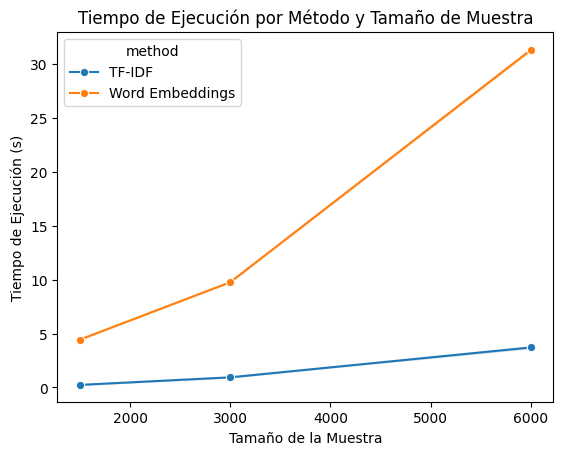

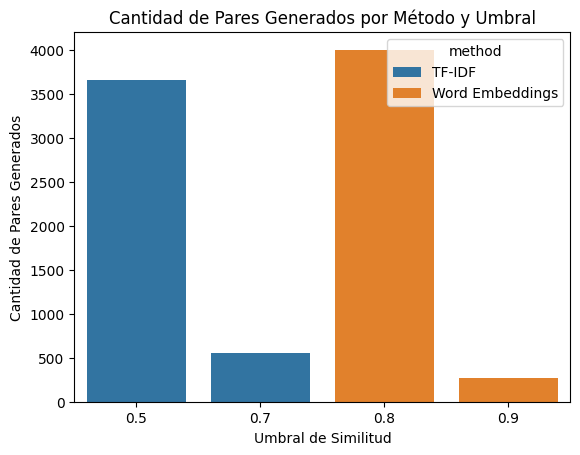

In [9]:
# Graficar tiempo de ejecución
sns.lineplot(data=results_df, x='sample_size', y='execution_time', hue='method', marker='o')
plt.xlabel('Tamaño de la Muestra')
plt.ylabel('Tiempo de Ejecución (s)')
plt.title('Tiempo de Ejecución por Método y Tamaño de Muestra')
plt.show()



# Graficar pares generados vs umbral y método
sns.barplot(data=results_df, x='threshold', y='rows_generated', hue='method', errorbar=None)
plt.xlabel('Umbral de Similitud')
plt.ylabel('Cantidad de Pares Generados')
plt.title('Cantidad de Pares Generados por Método y Umbral')
plt.show()

El método TDF-IDF resultó ser más eficiente computacionalmente para los tipos de datos solicitados con las muestras previamente evaluadas.

# **3) Mejor método: Metodo TF-IDF**

Se selecciona este método por su eficiencia computacional y porque, al hacer una comparación de palabra por palabra, tiene también una muy buena calidad de resultados generados.  

Se recomienda correr este método.

In [10]:
#Vectorización

vectorizer=TfidfVectorizer()  #max_features=10000, min_df=2)


tfidf_matrix = vectorizer.fit_transform(df['item_title_clean'])   # Acá creamos la matriz de "pesos" de cada palabra dentro de cada title.

# TF (Frecuencia de término): Cuenta cuántas veces aparece una palabra en un texto.
# IDF (Frecuencia inversa de documento): Penaliza las palabras que son muy comunes en todos los textos (como "el", "y", "de") porque no aportan mucho significado.

print("Orden de la matriz TF-IDF:" ,tfidf_matrix.shape)

#print("\n Primeros y últimos elementos de la matriz")
#print(tfidf_matrix)



Orden de la matriz TF-IDF: (30000, 17676)


Esta primera matriz generada por el método, es una matriz dispersa donde:

- cada fila representa un título (Por eso son 30.000)
- cada columna representa una palabra.

Los valores distintos de cero indican la presencia de la palabra dentro del título y su peso en el mismo.

Luego creamos la matriz de similaridad con la función cosine_similarity (basada en el producto escalar de los vectores)  

La matriz de similaridad representa en cada fila los títulos ordenados y en cada columna a los mismos títulos ordenados. Por lo que resulta en una matriz cuadrada con:
- unos en la diagonal principal (cada título es igual a sí mismo)
- valores entre cero y uno fuera de la diagonal que indican el grado de similaridad entre títulos

In [11]:
similarity_matrix = cosine_similarity(tfidf_matrix)
print(similarity_matrix)

print("\n Orden de la matriz de similaridad:" ,similarity_matrix.shape)

[[1.         0.         0.00797214 ... 0.         0.04749056 0.        ]
 [0.         1.         0.         ... 0.03466769 0.         0.        ]
 [0.00797214 0.         1.         ... 0.03846135 0.06745965 0.        ]
 ...
 [0.         0.03466769 0.03846135 ... 1.         0.05630399 0.        ]
 [0.04749056 0.         0.06745965 ... 0.05630399 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]

 Orden de la matriz de similaridad: (30000, 30000)


A continuación se genera la tabla con los pares de títulos (En su versión original) y sus similitudes:

In [12]:
pairs = []

for i in range(len(df)):
  for j  in range(i+1,len(df)):   #Esto empieza comparando 1 vs 2 hasta el final, luego 2 vs 3 hasta el final, luego 3 vs 4 hasta el final, etc. Nunca se duplican comparaciones

    score=similarity_matrix[i,j]
    if score > 0.5:
      pairs.append((df['ITE_ITEM_TITLE'][i], df['ITE_ITEM_TITLE'][j], round(score,3)))


# Creamos el dataframe de resultados
similarity_df = pd.DataFrame(pairs, columns=['item_title1','item_title2','Score Similitud'])
similarity_df = similarity_df.sort_values(by='Score Similitud', ascending=False)

similarity_df.head(10)

,item_title1,item_title2,Score Similitud
73649,Tênis Feminino Plataforma Moda Salto Alto,Tênis Feminino Plataforma Moda Salto Alto,1.0
102922,Tênis Oakley Flak 2 Black,Tênis Oakley Flak 2 Black,1.0
16782,Tênis Intruder Caterpillar,Tênis Intruder- Caterpillar,1.0
16744,Bicicleta Infantil Nathor Aro 12 Veloz Aro 12...,Bicicleta Infantil Nathor Aro 12 Veloz Aro 12...,1.0
59165,Tênis Via Marte Chuncky Feminino 20-14645,Tênis Feminino Via Marte Chuncky 20-14645,1.0
59160,Tênis Usando adidas,Tênis Usando adidas,1.0
98554,Tênis Feminino Capricho Preto Lanai Twill - Cp...,Tênis Feminino Capricho Lanai Twill Preto - Cp...,1.0
98466,Tênis Dad Sneaker Chunky Anttero Masculino Cou...,Tênis Dad Sneaker Chunky Anttero Masculino Cou...,1.0
40349,Sapatenis Masculino Sapato Solado Borracha Ten...,Sapatenis Tenis Masculino Solado Borracha Sapa...,1.0
115392,Molekinho Tênis Velcro Casual Conforto 2147 Be...,Tênis Molekinho Velcro Casual Conforto 2147 Be...,1.0


In [13]:
similarity_df.to_csv('Similarity_results_TDFIDF.csv',index=False)

**Distribución resultados del método TF-IDF**

A continuación se grafica la cantidad de similitudes por rango de score

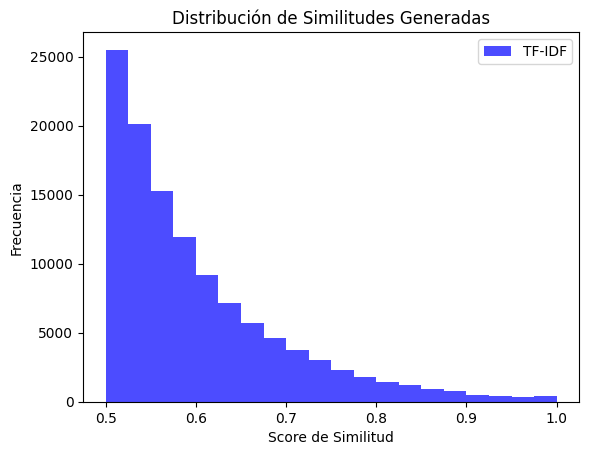

In [14]:
# Crear histograma de similitudes
plt.hist(similarity_df['Score Similitud'], bins=20, alpha=0.7, label='TF-IDF', color='blue')
plt.xlabel('Score de Similitud')
plt.ylabel('Frecuencia')
plt.title('Distribución de Similitudes Generadas')
plt.legend()
plt.show()


# **4) Método Word Embeddings (opcional)**

Este método demostró tener más tiempo de ejecución.

Y dado que su algoritmo califica las frases semánticamente, encuentra similitudes con puntajes más altos que la evaluación por palabra, por lo que en caso de seleccionarse se debe trabajar con un umbral más elevado.

A continuación se presenta el código pero no se recomienda correr este método.



In [15]:
# !pip install -q sentence-transformers

# Cargar el modelo preentrenado
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generar embeddings para los títulos
embeddings = model.encode(df['item_title_clean'], batch_size=128, show_progress_bar=True)

# Calcular similitudes entre títulos
similarity_matrix2 = util.cos_sim(embeddings, embeddings)

print(f"Dimensiones de la matriz de embeddings: {embeddings.shape}")  # Embeddings: filas x columnas
print(f"Dimensiones de la matriz de similitudes: {similarity_matrix2.shape}")  # Similaridad: cuadrada


Batches:   0%|          | 0/235 [00:00<?, ?it/s]

Dimensiones de la matriz de embeddings: (30000, 384)
Dimensiones de la matriz de similitudes: torch.Size([30000, 30000])


In [16]:
# Filtrar matriz con umbral directo
# Convertimos la matriz a dispersa para trabajar eficientemente
sparse_matrix = csr_matrix(similarity_matrix2)

# Aplicar un umbral para seleccionar sólo las similitudes relevantes (ejemplo > 0.95)
threshold = 0.8
#Al ser un método que captura significado semántico de las frases su precisón es más baja que la comparación de palabra por palabra, por lo que el umbral debe elevarse
sparse_matrix = sparse_matrix.multiply(sparse_matrix > threshold)

# Extraer pares de índices de similitudes: Extraemos solo las celdas no vacías de la matriz dispersa
coo_matrix = sparse_matrix.tocoo()
pairs = list(zip(coo_matrix.row, coo_matrix.col, coo_matrix.data))

# DataFrame con resultados
pairs_filtered = [(df['ITE_ITEM_TITLE'][i], df['ITE_ITEM_TITLE'][j], round(sim, 2)) for i, j, sim in pairs if i < j]
similarity_df3 = pd.DataFrame(pairs_filtered, columns=['ITE_ITEM_TITLE1', 'ITE_ITEM_TITLE2', 'Score Similitud'])
similarity_df3 = similarity_df3.sort_values(by='Score Similitud', ascending=False)

# Paso 4: Guardar resultados
# similarity_df3.to_csv('similarity_results_optimized.csv', index=False)
# print("Resultados guardados en similarity_results_optimized.csv")


# **5) Conclusiones**

El métodos planteado (TF-IDF con Similitud de Coseno) logró buenos resultados debido eficiencia en términos de memoria y procesamiento.

Además, los resultados son óptimos: el dataframe generado cumple adecuadamente con la similitud entre títulos.

Word Embeddings presentó un alto tiempo de ejecución lo que lo hace menos viable, al menos con los parámetros estudiados en este archivo.